In [0]:
from random import randint
from numpy import array
import numpy as np
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.optimizers import Adam

%matplotlib inline

DATA

In [0]:
data = []
with open('/content/drive/My Drive/request_seq.txt' , errors='ignore' ) as fin:
    fin.seek(0)
    d = fin.read(100000000) 

In [45]:
#Data is continous sequence.Each segment in the sequence separated by '\n'
#Each segment contains 3 items: number of request, request ID and size of requested file.
d[:100]

'1 778030675 13539\n2 3484637698 17635\n3 1130267045 152\n4 3423744231 616\n5 203613471 121\n6 1342928892 '

In [46]:
#Spliting the continous sequence
data = d.split()
data[:10]

['1',
 '778030675',
 '13539',
 '2',
 '3484637698',
 '17635',
 '3',
 '1130267045',
 '152',
 '4']

In [47]:
del d
len(data)

12722261

In [0]:
#We are interested in number of request and request id.
req = []
for i in range(len(data)):
  r = []
  if (i-1)%3 == 0 and len(req)<2005000:
    r.append(data[i])
    #To convert string into real numbers. 
    temp = 0
    for j in range(len(r[0])):
      temp = temp + int(r[0][j])*pow(10,len(r[0])-j-1)
    req.append(temp)

In [49]:
req = np.array(req)
req.shape

(2005000,)

In [50]:
total_id = len(np.unique(req))
print(total_id)

763307


In [51]:
#To find the range of request id
min = np.min(req)
max = np.max(req)
min,max

(2301, 4294966263)

In [0]:
# To reduce total numbers of ID
id = 50
factor = (max - min)/(id-1)
req1 = []
for i in range(len(req)):
  req1 .append(int(np.divide(req[i],factor)))

In [0]:
# For bipartite network, Distributing request among 10 users
users = 5
req_user = []
for i in range(int(len(req1)/users)):
  temp = []
  for j in range(i*users,(i+1)*users):
    temp.append(req1[j])
  req_user.append(temp)

In [54]:
req_user = np.array(np.transpose(req_user))
req_user.shape

(5, 401000)

In [0]:
del req, req1, temp, data, r

In [56]:
count = np.zeros((users,id), dtype = 'float')
for i in range(users):
  for j in range(1000):
    count[i,int(req_user[i][j])] += 1
count.shape

(5, 50)

In [0]:
prob = np.zeros((users,len(req_user[0])-1000,id), dtype = 'f4')

In [0]:
for i in range(users):
  for j in range(len(req_user[0])-1000):
    count[i,int(req_user[i,j+1000])] += 1
    count[i,int(req_user[i,j])] -= 1
    prob[i,j,:] = count[i,:]/1000

In [59]:
prob.shape

(5, 400000, 50)

In [0]:
del count

In [61]:
batch_size = 15000
encoder_input_data = prob[:,:300000,:].reshape(20*users,batch_size,id) # total samples per users = 20
encoder_input_data.shape

(100, 15000, 50)

In [62]:
decoder_target_data = []
K = 10 # Next sequence to be predicted
for i in range(1,21):
    temp = []
    for j in range(K): # to predict next 10 req for every batch
        temp.append(prob[:,(batch_size*i) + j,:])
    decoder_target_data.append(temp)    

decoder_target_data = np.array(decoder_target_data).reshape(20*users,K,id)
decoder_target_data.shape

(100, 10, 50)

In [63]:
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[1:,:,:] = decoder_target_data[:-1,:,:]
decoder_input_data[0,:,:] = encoder_input_data[-1,-1,:]
decoder_input_data.shape

(100, 10, 50)

MODEL


In [0]:
latent_dim = 128 # LSTM hidden units
dropout = 0.1

In [0]:
encoder_inputs = Input(shape=(None, 50)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

In [0]:
decoder_inputs = Input(shape=(None, 50)) 
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

In [0]:
decoder_outputs = Dense(50, activation='softmax')(decoder_outputs)

In [68]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, 50)     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None, 50)     0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 128), (None, 91648       input_5[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 128),  91648       input_6[0][0]                    
                                                                 lstm_3[0][1]               

In [69]:
model.compile(Adam(), loss='mean_squared_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=batch_size,epochs=30)

Epoch 1/30
100/100 [==============================] - 45s 453ms/step - loss: 3.2019e-05
Epoch 2/30
100/100 [==============================] - 44s 436ms/step - loss: 3.1936e-05
Epoch 3/30
100/100 [==============================] - 43s 434ms/step - loss: 3.1838e-05
Epoch 4/30
100/100 [==============================] - 43s 431ms/step - loss: 3.1698e-05
Epoch 5/30
100/100 [==============================] - 43s 429ms/step - loss: 3.1562e-05
Epoch 6/30
100/100 [==============================] - 43s 432ms/step - loss: 3.1404e-05
Epoch 7/30
100/100 [==============================] - 43s 431ms/step - loss: 3.1255e-05
Epoch 8/30
100/100 [==============================] - 42s 424ms/step - loss: 3.1098e-05
Epoch 9/30
100/100 [==============================] - 43s 426ms/step - loss: 3.0925e-05
Epoch 10/30
100/100 [==============================] - 42s 421ms/step - loss: 3.0766e-05
Epoch 11/30
100/100 [==============================] - 42s 422ms/step - loss: 3.0606e-05
Epoch 12/30
100/100 [=========

PREDICTION OF FUTURE REQUESTS


In [0]:
encoder_model = Model(encoder_inputs, encoder_states)
pred_steps = 10

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = Dense(50, activation='softmax')(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

In [0]:
def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 50))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, :] = input_seq[0, -1, :]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,50))
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,:] = output[0,0,:]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 50))
        target_seq[0, 0, :] = output[0,0,:]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [72]:
prob.shape

(5, 400000, 50)

In [73]:
n = int((len(prob[0]) - batch_size)/1000)
n

385

In [74]:
prediction = []
for i in range(users):
  print(i)
  temp = []
  for j in range(1000):
    temp.append(decode_sequence(prob[i,int(j*n) : int(j*n + 15000),:].reshape(1,15000,50)))
  prediction.append(temp)

0
1
2
3
4


In [75]:
prediction = np.array(prediction).reshape(users,1000,10,id)
prediction.shape

(5, 1000, 10, 50)

In [76]:
prediction[0,0,0]

array([0.02023662, 0.02083804, 0.02057384, 0.02002467, 0.01923002,
       0.02042399, 0.02101225, 0.02008013, 0.01979596, 0.02058708,
       0.02032961, 0.01958279, 0.01978235, 0.01998281, 0.01938253,
       0.02001707, 0.02019578, 0.01995417, 0.01976968, 0.02050448,
       0.02058572, 0.01969059, 0.02057916, 0.02020312, 0.0199188 ,
       0.0195139 , 0.0202997 , 0.01935707, 0.0197097 , 0.02066957,
       0.01895418, 0.01989372, 0.01997029, 0.01984722, 0.02053131,
       0.02011227, 0.02010409, 0.02003513, 0.01990397, 0.01963427,
       0.01969289, 0.0197746 , 0.02000872, 0.01938578, 0.02034562,
       0.01966355, 0.01992566, 0.01901824, 0.02024199, 0.02012529])

GENERATION OF FAKE REQUESTS

In [77]:
fake_req = []
for i in range(users):
  t = []
  for j in range(1000):
    temp = []
    for k in range(10):
      for l in range(id):
        if prediction[i,j,k,l] > sorted(prediction[i,j,k],reverse = 1)[5]:
          temp.append(l)
    while len(temp) < 50:
      temp.append(0)
    t.append(temp)
  fake_req.append(t)
fake_req = np.array(fake_req) 
fake_req.shape

(5, 1000, 50)

In [78]:
400000 + 1000*50

450000

In [0]:
generated_req = []
for l in range(users):
  request = []
  for i in range(batch_size):
    request.append(req_user[l,i])
  for i in range(50):
    request.append(fake_req[l,0,i])
  for i in range(1000):
    for j in range(n + 50):
      if j < n:
        request.append(req_user[l,10000 + j + n*i])
      elif(i>0):
        request.append(fake_req[l,i,j-n])
  generated_req.append(request)

In [80]:
generated_req = np.array(generated_req)
generated_req.shape

(5, 450000)

In [0]:
del prediction,fake_req,request,t,temp

CACHING POLICIES

In [82]:
req_user.shape

(5, 401000)

In [85]:
# LRU
from memoization import cached, CachingAlgorithmFlag
@cached(max_size=5, algorithm=CachingAlgorithmFlag.LRU)
def get_url(resource):
    try:
        
        with urllib.request.urlopen(resource) as s:
            return True
    except Exception as e:
        return False
    
hit_LRU = []
miss_LRU = []
for i in range(users):
  for j in range(len(req_user[i])):
    get_url(req_user[i,j])
    hit_LRU.append(get_url.cache_info().hits)
    miss_LRU.append(get_url.cache_info().misses)
get_url.cache_info()

CacheInfo(hits=206522, misses=1798478, current_size=5, max_size=5, algorithm=<CachingAlgorithmFlag.LRU: 2>, ttl=None, thread_safe=True, order_independent=False, use_custom_key=False)

In [86]:
# LFU

from memoization import cached, CachingAlgorithmFlag
@cached(max_size=5, algorithm=CachingAlgorithmFlag.LFU)
def get_url(resource):
    try:
        
        with urllib.request.urlopen(resource) as s:
            return True
    except Exception as e:
        return False
    
hit_LFU = []
miss_LFU = []
for i in range(users):
  for j in range(len(req_user[i])):
    get_url(req_user[i,j])
    hit_LFU.append(get_url.cache_info().hits)
    miss_LFU.append(get_url.cache_info().misses)
get_url.cache_info()

CacheInfo(hits=208078, misses=1796922, current_size=5, max_size=5, algorithm=<CachingAlgorithmFlag.LFU: 4>, ttl=None, thread_safe=True, order_independent=False, use_custom_key=False)

In [87]:
# LSTM_LRU

from memoization import cached, CachingAlgorithmFlag
@cached(max_size=5, algorithm=CachingAlgorithmFlag.LRU)
def get_url(resource):
    try:
        
        with urllib.request.urlopen(resource) as s:
            return True
    except Exception as e:
        return False
    
hit_LSTM_LRU = []
miss_LSTM_LRU = []
for i in range(users):
  for j in range(len(req_user[i])):
    get_url(generated_req[i,j])
    hit_LSTM_LRU.append(get_url.cache_info().hits)
    miss_LSTM_LRU.append(get_url.cache_info().misses)
get_url.cache_info()

CacheInfo(hits=366802, misses=1638198, current_size=5, max_size=5, algorithm=<CachingAlgorithmFlag.LRU: 2>, ttl=None, thread_safe=True, order_independent=False, use_custom_key=False)

In [88]:
def distance(i,id,n):
  if n == len(generated_req[i]):
    return 0
  else:
    j = n + 1
    while generated_req[i,j] != id and j < len(generated_req[i]):
        j += 1
        if j == len(generated_req[i]):
          break
    return j-n

size = 5
hit = 0
miss = 0
hit_LSTM_min = []
miss_LSTM_min = []
cache = []

for i in range(users):
  for j in range(len(req_user[i])):
    # If cache is empty then add requested item
    if len(cache) < size:
        cache.append(generated_req[i,j])
    # otherwise evict one item and add requested
    else:   
        # Chech if requested item is present in cache or not
        count = 0
        for k in range(size):
            if generated_req[i,j] == cache[k]:
                count += 1
        # If not present evict one item
        if count == 0: 
            miss += 1
            # calculate distance for each cached item
            d = []
            for k in range(size):
                d.append(distance(i,cache[k],j))
            d = np.array(d)
            #find item with max distance 
            for k in range(size):
                if np.max(d) == d[k]:
                    cache[k] = generated_req[i,j]
        # If requested item is already in cache then hit
        else:
            hit += 1
    hit_LSTM_min.append(hit)
    miss_LSTM_min.append(miss)
    
print(hit,miss)

762338 1242657


In [89]:
C = 5
I = users
J = 1
N = id
pi = 3.14
n = I*pow(4*pi*np.log(N*I),-.25)*pow(len(req_user[0])/(J*C),.5)
count = np.zeros(N)

x = np.zeros(50)
for i in range(50):
    x[i] = i
var = np.eye(50)
gauss = np.dot(np.exp(-0.5*pow(np.dot(var,x),2)),var)/pow(2*pi,0.5)
gauss.shape

(50,)

In [90]:
hit_FTPL = []
miss_FTPL = []
hit = 0
miss = 0

for i in range(users):
  for j in range(len(req_user[i]-1)):
    t = int(req_user[i,j]) - 1
    count[t] += 1
    perturbed_count = count + n*gauss
    cache = []
    if j <= C:
        cache.append(req_user[i,j])
    else:
        for k in range(N):
            if perturbed_count[k] >= sorted(perturbed_count,reverse = 1)[C-1] and len(cache) < C:
                    cache.append(k+1)
        if len(cache) != C:
            print(i,len(cache))
        x = 0        
        for l in range(C):
            if req_user[i,j] == cache[l]:
                x += 1
        if x>0:
            hit += 1
        else:
            miss += 1
        hit_FTPL.append(hit)
        miss_FTPL.append(miss)
print(hit,miss)

245328 1759642


Text(0, 0.5, 'Hit-rate')

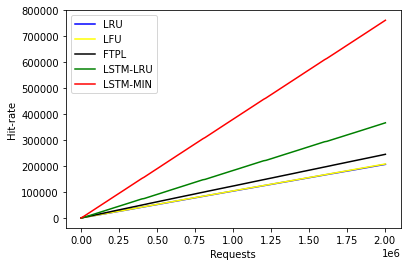

In [91]:
plt.plot(hit_LRU,'blue',label = 'LRU')
plt.plot(hit_LFU,'yellow',label = 'LFU')
plt.plot(hit_FTPL,'black',label = 'FTPL')
plt.plot(hit_LSTM_LRU,'green',label = 'LSTM-LRU')
plt.plot(hit_LSTM_min,'red',label = 'LSTM-MIN')
plt.legend()
plt.xlabel('Requests')
plt.ylabel('Hit-rate')

Text(0, 0.5, 'Miss-rate')

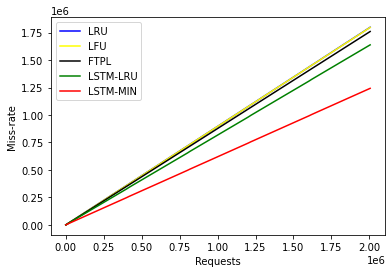

In [92]:
plt.plot(miss_LRU,'blue',label = 'LRU')
plt.plot(miss_LFU,'yellow',label = 'LFU')
plt.plot(miss_FTPL,'black',label = 'FTPL')
plt.plot(miss_LSTM_LRU,'green',label = 'LSTM-LRU')
plt.plot(miss_LSTM_min,'red',label = 'LSTM-MIN')
plt.legend()
plt.xlabel('Requests')
plt.ylabel('Miss-rate')

TEST CASE

In [0]:
# We have used 300k requests per users to train model.
# Now we test this model for 300k to 400k requests for each model.

In [94]:
req_user_test = req_user[:,300000:400000]
req_user_test.shape

(5, 100000)

In [95]:
(300000 - 15000)*50/n

29041.4693948263

In [96]:
generated_req_test = generated_req[:,313000:413000]
generated_req_test.shape

(5, 100000)

In [97]:
# LRU
from memoization import cached, CachingAlgorithmFlag
@cached(max_size=5, algorithm=CachingAlgorithmFlag.LRU)
def get_url(resource):
    try:
        with urllib.request.urlopen(resource) as s:
            return True
    except Exception as e:
        return False
    
hit_LRU_test = []
miss_LRU_test = []
for i in range(users):
  for j in range(len(req_user_test[i])):
    get_url(req_user_test[i,j])
    hit_LRU_test.append(get_url.cache_info().hits)
    miss_LRU_test.append(get_url.cache_info().misses)
get_url.cache_info()

CacheInfo(hits=51805, misses=448195, current_size=5, max_size=5, algorithm=<CachingAlgorithmFlag.LRU: 2>, ttl=None, thread_safe=True, order_independent=False, use_custom_key=False)

In [98]:
# LFU
from memoization import cached, CachingAlgorithmFlag
@cached(max_size=5, algorithm=CachingAlgorithmFlag.LRU)
def get_url(resource):
    try:
        with urllib.request.urlopen(resource) as s:
            return True
    except Exception as e:
        return False
    
hit_LFU_test = []
miss_LFU_test = []
for i in range(users):
  for j in range(len(req_user_test[i])):
    get_url(req_user_test[i,j])
    hit_LFU_test.append(get_url.cache_info().hits)
    miss_LFU_test.append(get_url.cache_info().misses)
get_url.cache_info()

CacheInfo(hits=51805, misses=448195, current_size=5, max_size=5, algorithm=<CachingAlgorithmFlag.LRU: 2>, ttl=None, thread_safe=True, order_independent=False, use_custom_key=False)

In [99]:
# LSTM_LRU

from memoization import cached, CachingAlgorithmFlag
@cached(max_size=5, algorithm=CachingAlgorithmFlag.LRU)
def get_url(resource):
    try:
        
        with urllib.request.urlopen(resource) as s:
            return True
    except Exception as e:
        return False
    
hit_LSTM_LRU_test = []
miss_LSTM_LRU_test = []
for i in range(users):
  for j in range(len(req_user_test[i])):
    get_url(generated_req_test[i,j])
    hit_LSTM_LRU_test.append(get_url.cache_info().hits)
    miss_LSTM_LRU_test.append(get_url.cache_info().misses)
get_url.cache_info()

CacheInfo(hits=93200, misses=406800, current_size=5, max_size=5, algorithm=<CachingAlgorithmFlag.LRU: 2>, ttl=None, thread_safe=True, order_independent=False, use_custom_key=False)

In [100]:
def distance(i,id,x):
  j = x + 1
  while generated_req_test[i,j] != id and j < len(generated_req_test[i])-1:
        j += 1
  return j-x

size = 5
hit = 0
miss = 0
hit_LSTM_min_test = []
miss_LSTM_min_test = []
cache = []

for i in range(users):
  for j in range(99000):
    # If cache is empty then add requested item
    if len(cache) < size:
        cache.append(generated_req_test[i,j])
    # otherwise evict one item and add requested
    else:   
        # Chech if requested item is present in cache or not
        count = 0
        for k in range(size):
            if generated_req_test[i,j] == cache[k]:
                count += 1
        # If not present evict one item
        if count > 0:
          hit += 1
        else: 
          miss += 1
          # calculate distance for each cached item
          d = []
          for k in range(size):
            d.append(distance(i,cache[k],j))
          d = np.array(d)
          #find item with max distance 
          for k in range(size):
            if np.max(d) == d[k]:
              cache[k] = generated_req_test[i,j]
        # If requested item is already in cache then hit
    hit_LSTM_min_test.append(hit)
    miss_LSTM_min_test.append(miss)
    
print(hit,miss)

189290 305705


In [101]:
len(hit_LSTM_min_test)

495000

In [102]:
C = 5
I = users
J = 1
N = id
pi = 3.14
n = I*pow(4*pi*np.log(N*I),-.25)*pow(len(req_user_test[0])/(J*C),.5)
count = np.zeros(N)

x = np.zeros(50)
for i in range(50):
    x[i] = i
var = np.eye(50)
gauss = np.dot(np.exp(-0.5*pow(np.dot(var,x),2)),var)/pow(2*pi,0.5)
gauss.shape

(50,)

In [103]:
#FTPL
hit_FTPL_test = []
miss_FTPL_test = []
hit = 0
miss = 0

for i in range(users):
  for j in range(len(req_user_test[i])):
    t = int(req_user_test[i,j]) - 1
    count[t] += 1
    perturbed_count = count + n*gauss
    cache = []
    if j <= C:
        cache.append(req_user_test[i,j])
    else:
        for k in range(N):
            if perturbed_count[k] >= sorted(perturbed_count,reverse = 1)[C-1] and len(cache) < C:
                    cache.append(k+1)
        if len(cache) != C:
            print(i,len(cache))
        x = 0        
        for l in range(C):
            if req_user_test[i,j] == cache[l]:
                x += 1
        if x>0:
            hit += 1
        else:
            miss += 1
        hit_FTPL.append(hit)
        miss_FTPL.append(miss)
print(hit,miss)

60320 439650


Text(0, 0.5, 'Hit-rate')

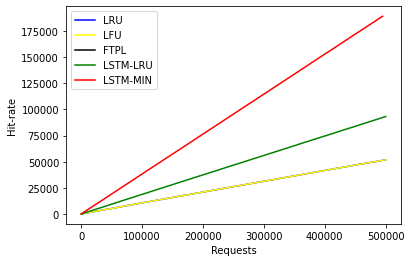

In [104]:
plt.plot(hit_LRU_test,'blue',label = 'LRU')
plt.plot(hit_LFU_test,'yellow',label = 'LFU')
plt.plot(hit_FTPL_test,'black',label = 'FTPL')
plt.plot(hit_LSTM_LRU_test,'green',label = 'LSTM-LRU')
plt.plot(hit_LSTM_min_test,'red',label = 'LSTM-MIN')
plt.legend()
plt.xlabel('Requests')
plt.ylabel('Hit-rate')

Text(0, 0.5, 'Miss-rate')

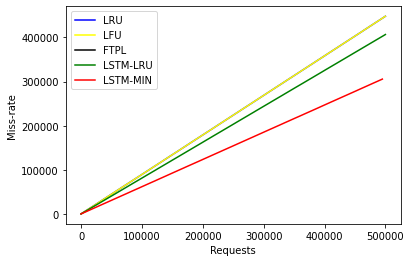

In [105]:
plt.plot(miss_LRU_test,'blue',label = 'LRU')
plt.plot(miss_LFU_test,'yellow',label = 'LFU')
plt.plot(miss_FTPL_test,'black',label = 'FTPL')
plt.plot(miss_LSTM_LRU_test,'green',label = 'LSTM-LRU')
plt.plot(miss_LSTM_min_test,'red',label = 'LSTM-MIN')
plt.legend()
plt.xlabel('Requests')
plt.ylabel('Miss-rate')